# Emotions classifier 

## Project scope

<p>The scope of this project is to create a classifier of human emotion expressed through text obtained from publicly available tweets. </p>

## Imports

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import re
import contractions
from nltk.stem import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Exploratory data analysis

<p>Let's get to actually know our data and determine what we'll have to do with it in the preprocessing section, before we can proceed to training a classifier model on it.</p>

In [3]:
tweets_data = pd.read_csv('./Data/tweet_emotions.csv')

In [4]:
tweets_data.head(10)

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
5,1956968477,worry,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,"I should be sleep, but im not! thinking about ..."
7,1956968636,worry,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,@charviray Charlene my love. I miss you
9,1956969172,sadness,@kelcouch I'm sorry at least it's Friday?


<p>I see we'll have to deal with special characters, elongated leters, inaccurate grammar, etc. Let's see how big is the dataset. </p>

In [5]:
tweets_data.describe()

,tweet_id
count,4.000000e+04
mean,1.845184e+09
std,1.188579e+08
min,1.693956e+09
25%,1.751431e+09
50%,1.855443e+09
75%,1.962781e+09
max,1.966441e+09


<p>Ok, we have 40000 records inside of our dataset, which means that we'll have to, eventually, break down the preprocessing iterative part into batches of smaller data, so that it all gets done quickly and less costly in terms of memory and processing power. </p>

<p>Let's see all of our sentiment classes, this is what we'll train our model to predict based on an input text.</p>

In [6]:
tweets_data['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

<p>Ok, apparently we'll have to do multi-class classification, so logistic regression is out of the question for our classification model. Perhaps we could use K-Nearest Neighbour or a naive bayes classifier? Maybe even a random forest one? </p>

<p>We should also see if our dataset, in terms of sentiments, is balanced i.e. if the dataset does not contain mostly enthusiasm or some other sentiment. </p>

<AxesSubplot: >

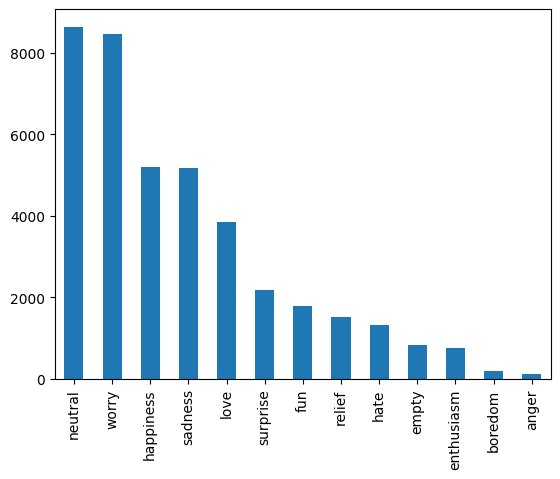

In [7]:
tweets_data['sentiment'].value_counts().plot(kind='bar')

<p>Obviously the model, with the current data, will be incredibly biased toward neutral and worry emotions because they make up most of the dataset. That's a problem we have to deal with. One way we could do that is to duplicate the lower values until they get up to the scale of the neutral and worry sentiments? Another one, which to me seems a lot more practical, is to use weighted loss for the classification model. Basically, we'll use scikit learn and tell it to assign a weight to all the sentiments that is inversely proportional to the sentiment's frequency in the dataset.</p>

# Data preprocessing

<p>Let's deal with the unbalanced dataset first, we'll do oversampling, although we probably risk to cause overfitting by doing that. </p>

<p>We'll calculate the amount of records we need to meet the class with the most records in our dataset and, by subtracting the amount of records we have in any other class from the class with the most records. Then we'll use the pandas sample method to do the sampling/repeating the data for us. </p>

<p>I think we should set up a threshold for oversampling certain columns or not, because we need to oversample the most "under represented" classes. Let's set that up to be the difference between the highest amount of records in a given class and the amount of records in any other class.</p> 

In [8]:
oversampling_threshold = 4000

In [9]:
needed_data_points = tweets_data[tweets_data['sentiment'] == 'neutral'].count()['sentiment'] - tweets_data[tweets_data['sentiment'] == 'anger'].count()['sentiment']

In [10]:
oversampled_tweets_data = pd.DataFrame(columns=['sentiment', 'content'])
for sentiment in tweets_data['sentiment'].unique():
    needed_data_points = tweets_data[tweets_data['sentiment'] == 'neutral'].count()['sentiment'] - tweets_data[tweets_data['sentiment'] == sentiment].count()['sentiment']
    if needed_data_points >= oversampling_threshold:
        oversampled_data = tweets_data[tweets_data['sentiment'] == sentiment].sample(n = needed_data_points, replace=True)
        oversampled_tweets_data = pd.concat([oversampled_data, oversampled_tweets_data])
    else:
        oversampled_tweets_data = pd.concat([tweets_data[tweets_data['sentiment'] == sentiment], oversampled_tweets_data])

<AxesSubplot: >

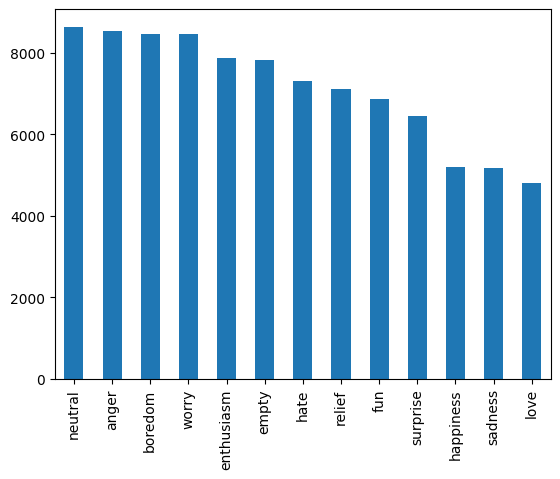

In [11]:
oversampled_tweets_data['sentiment'].value_counts().plot(kind='bar')

<p> I think that's a lot better, compared to the first graph of the original dataset, although we could be risking overfitting - we've repeated a lot of the data in a given class to meet a certain number of records. </p>

<p> Let's get to the main part. First, we'll have to seperate the tweets into words, and then remove the stopwords and make all the words lower case, so that we don't get any unpleasant surprises later on. </p>

In [12]:
tweets = oversampled_tweets_data['content']

In [13]:
words_tokenized_tweets = [word_tokenize(tweet_sentence) for tweet_sentence in tweets]

In [14]:
words_tokenized_tweets[0:5]

[['sam',
  'and',
  'sean',
  'are',
  'teasing',
  'me',
  'saying',
  'they',
  'are',
  'gon',
  'na',
  'get',
  'wings',
  'without',
  'me'],
 ['Apperently',
  'ea',
  'knows',
  'my',
  'copy',
  'of',
  'the',
  'sims',
  '3',
  'is',
  'not',
  'legit',
  'and',
  'is',
  'upset'],
 ['sam',
  'and',
  'sean',
  'are',
  'teasing',
  'me',
  'saying',
  'they',
  'are',
  'gon',
  'na',
  'get',
  'wings',
  'without',
  'me'],
 ['@',
  'kristanmarie',
  'at',
  'least',
  'you',
  'dont',
  'have',
  'quad',
  'parking',
  'haha',
  'two',
  'cars',
  'drove',
  'by',
  'real',
  'fast',
  'and',
  'spashed',
  'mud',
  'all',
  'over',
  'me'],
 ['Wow',
  ',',
  'I',
  "'m",
  'really',
  'bored',
  '...',
  'and',
  'pissed',
  'I',
  'left',
  'my',
  'library',
  'card',
  'when',
  'I',
  'had',
  'to',
  'take',
  'the',
  'Booky',
  'Wook',
  'back',
  '...']]

In [15]:
no_stopwords = [[word.lower() for word in tweet if word not in set(stopwords.words('english'))] for tweet in words_tokenized_tweets ]

In [16]:
no_stopwords[0]

['sam', 'sean', 'teasing', 'saying', 'gon', 'na', 'get', 'wings', 'without']

<p>It seems to be working, no stopwords seem to be present here. Now, let's remove anything that's not a word (I assume that excalamation and question marks do not show that much of an emotion as the individual words used in the context of the entire tweet). We'll use a regex for that. </p>

In [17]:
words_only_sentences = [[word for word in tweet if not re.match('\W+|\d+', word) ] for tweet in no_stopwords ]

In [18]:
words_only_sentences[0:5]

[['sam', 'sean', 'teasing', 'saying', 'gon', 'na', 'get', 'wings', 'without'],
 ['apperently', 'ea', 'knows', 'copy', 'sims', 'legit', 'upset'],
 ['sam', 'sean', 'teasing', 'saying', 'gon', 'na', 'get', 'wings', 'without'],
 ['kristanmarie',
  'least',
  'dont',
  'quad',
  'parking',
  'haha',
  'two',
  'cars',
  'drove',
  'real',
  'fast',
  'spashed',
  'mud'],
 ['wow',
  'i',
  'really',
  'bored',
  'pissed',
  'i',
  'left',
  'library',
  'card',
  'i',
  'take',
  'booky',
  'wook',
  'back']]

<p> It seems to have worked, now we have to take care of the so called contraction words, such as: don't, can't, won't, etc. We'll expand them like so: don't - do not, can't - cannot, etc. </p>

In [19]:
words_only_sentences = [[contractions.fix(word) for word in tweet] for tweet in words_only_sentences ]

In [20]:
words_only_sentences[0:5]

[['sam', 'sean', 'teasing', 'saying', 'gon', 'na', 'get', 'wings', 'without'],
 ['apperently', 'ea', 'knows', 'copy', 'sims', 'legit', 'upset'],
 ['sam', 'sean', 'teasing', 'saying', 'gon', 'na', 'get', 'wings', 'without'],
 ['kristanmarie',
  'least',
  'do not',
  'quad',
  'parking',
  'haha',
  'two',
  'cars',
  'drove',
  'real',
  'fast',
  'spashed',
  'mud'],
 ['wow',
  'i',
  'really',
  'bored',
  'pissed',
  'i',
  'left',
  'library',
  'card',
  'i',
  'take',
  'booky',
  'wook',
  'back']]

<p> We have to, finally, lemmatize every word in our dataset. That means we'll turn every word into its base form, based on a look-up in a dictionary -> Running - run, planes -> plane, etc. The reason we want to use lemmatization over stemmatization is that lemmatization, at least in my humble experience, seems to give us words that make sense and are grammatically correct. On the other hand, stemmatization is known to give us results, such as: Flying -> Flyi, Running -> Runn, etc. We want to avoid that, even at the price of a more computationally expensive method (lemmatization).</p>

<p> We will use NLTK's word net lemmatizer. </p>

In [21]:
lemmatizer = WordNetLemmatizer()

In [22]:
lemmatized_verbs_words = [[lemmatizer.lemmatize(word, pos='v') for word in sentence] for sentence in words_only_sentences]

In [23]:
lemmatized_verbs_words[0:5]

[['sam', 'sean', 'tease', 'say', 'gon', 'na', 'get', 'wing', 'without'],
 ['apperently', 'ea', 'know', 'copy', 'sims', 'legit', 'upset'],
 ['sam', 'sean', 'tease', 'say', 'gon', 'na', 'get', 'wing', 'without'],
 ['kristanmarie',
  'least',
  'do not',
  'quad',
  'park',
  'haha',
  'two',
  'cars',
  'drive',
  'real',
  'fast',
  'spashed',
  'mud'],
 ['wow',
  'i',
  'really',
  'bore',
  'piss',
  'i',
  'leave',
  'library',
  'card',
  'i',
  'take',
  'booky',
  'wook',
  'back']]

<p>It seems to be working for the correctly written verbs. A problem that arrises here is that we have incorrect words, such as "layin" which is supposed to be "laying". The lemmatizer doesn't finy such a word in WordNet and returns the original input (as specified in the documentation). One way I can think of dealing with that problem is if we have a COMPLETE list of all words in english and all their forms in all tenses and applying an edit distance algorithm over them, as to see which word is closest to the current word. Levenshtein distance would do well in that case, but we won't go as deep in this notebook and we'll leave that as it is. </p>

Next, we'll lematize everything, but the verbs (as we've already lemmatized them earlier). If you notice we do not pass any pos(part of speech) parameter to the lemmatizer here, that is because if we don't specify the POS tag to lemmatize, everything else but the verbs is lemmatized. </p>

In [24]:
lemmatized_everything_else_words = [[lemmatizer.lemmatize(word) for word in sentence] for sentence in lemmatized_verbs_words]

In [25]:
lemmatized_everything_else_words[0:5]

[['sam', 'sean', 'tease', 'say', 'gon', 'na', 'get', 'wing', 'without'],
 ['apperently', 'ea', 'know', 'copy', 'sims', 'legit', 'upset'],
 ['sam', 'sean', 'tease', 'say', 'gon', 'na', 'get', 'wing', 'without'],
 ['kristanmarie',
  'least',
  'do not',
  'quad',
  'park',
  'haha',
  'two',
  'car',
  'drive',
  'real',
  'fast',
  'spashed',
  'mud'],
 ['wow',
  'i',
  'really',
  'bore',
  'piss',
  'i',
  'leave',
  'library',
  'card',
  'i',
  'take',
  'booky',
  'wook',
  'back']]

<p>Let's now join the data together so that each sentence is complete and it refers to the correct index in the original data frame, this is because we'll later create a new data frame and we'll want to link each tweet with its original sentiment. </p>

In [26]:
joined_preprocessed_tweets = [" ".join(tweet_words) for tweet_words in lemmatized_everything_else_words]

In [27]:
joined_preprocessed_tweets[0:5]

['sam sean tease say gon na get wing without',
 'apperently ea know copy sims legit upset',
 'sam sean tease say gon na get wing without',
 'kristanmarie least do not quad park haha two car drive real fast spashed mud',
 'wow i really bore piss i leave library card i take booky wook back']

In [28]:
vectorizer = TfidfVectorizer()

In [29]:
Tfidf_Matrix = vectorizer.fit_transform(joined_preprocessed_tweets)

<p>Now, we'll create the preprocessed data frame that we'll use for the training of our models later on. </p>

In [30]:
tweets_preprocessed = pd.DataFrame(Tfidf_Matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [31]:
tweets_preprocessed.head(10)

,01,07,09,10,100,11,12am,131,15,1654,...,½ureo,½ve,½we,½who,½why,½whyyy,½y,½you,½z,½ï
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
preprocessed_tweets_df= pd.DataFrame({'content':joined_preprocessed_tweets, 'sentiment': oversampled_tweets_data['sentiment']})

In [33]:
preprocessed_tweets_df.head(5)

,content,sentiment
14082,sam sean tease say gon na get wing without,anger
17521,apperently ea know copy sims legit upset,anger
14082,sam sean tease say gon na get wing without,anger
11694,kristanmarie least do not quad park haha two c...,anger
11136,wow i really bore piss i leave library card i ...,anger


<p> I think we're ready with the preprocessing, we've achieved what we set out to achieve earlier in this section. Let's move on to the models building.</p>

# Models buidling

<p> As mentioned at the beginning of this notebook, we'll use either K-Nearest Neighbour(KNN) or a Naive Bayes Classificator, because it seems that these two are well-suited for our task (multi-class classification). Let's take a look at each of them, starting with K-Nearest Neighbour.</p>

## K-Nearest Neighbour (KNN)

<p>KNN is a supervised learning algorithm, which means that it needs a human (or any other sentient, intelligent being/creature/machine for that matter) to "show" it the correct way to classify whatever it's supposed to classify - be it images, user profiles, fake profiles, etc. </p>

<p>The reason we should consider KNN is because it does very well on classification tasks such as our task. It also does well with large sets of data, as most supervised learning algorithms in fact.</p>

### K-Nearest Neighbour inner workings

<p>Let's see what's behind the scenes of KNN, and what exactly does "K" stand for. </p>

<p>When we plot our data points on a plot for the purpose of classification it usually tends to follow patterns, where a certain class data point positions itself around similar class data points, thus forming a cluster. Whenever we want to classify a new data, say a tweet as in our case, we just turn the data into numerical form(if it is not in such a form yet), plot it on that plot and we look for the closest neighbours to our data point. This is where "K" comes in. K stands for the amount of closest neighbors we want. The cluster of a given class of closest neighbours to our data points is considered to be the predicted class of our input data. As for the way the distance between each data point and our input data, it is euclidean distance and it uses the euclidean distance formula. It's probably appropriate to mention that it's also a good practice to set "K" to odd values such as 3 or 5, so that we don't get a tie between a couple of classes. Hopefully, that's clear enough. Let's get to the model building part. </p>

### K-Nearest Neighbour implementation

<p> First, we'll define our X and Y variables, respectively the given and predicted data - the tweet content and the predicted sentiment for the given tweet. We'll train our models on the tweets data, so we'll send in the vectorized data there, so that the computer could understand human text.</p>

In [34]:
Y =  oversampled_tweets_data['sentiment']

In [35]:
X = Tfidf_Matrix

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, random_state=42)

<p>Here, we define our model usin SKLearn, I randomly picked 7 neighbours, so let's see the model's accuracy. </p>

In [37]:
KNN_Classifier = KNeighborsClassifier(n_neighbors=7)

In [38]:
KNN_model = KNN_Classifier.fit(X_train,Y_train)

In [39]:
y_pred = KNN_model.predict(X_test)

In [40]:
accuracy_score(y_pred, Y_test)

0.6866975941309742

<p>Not bad. Let's no do something called the elbow method. That's a method that lets us try different values of a given parameter and check the model's respective accuracy. Say we start with 3 neighbours and we get an accuracy of 50%, how much more can we increase the neighbours amount get a higher accuracy with minimalistic increase in neighbours amount. </p>

In [41]:
scores = []
neighbours_amounts = []
for n_neighbours in range(3,20):
    KNN_Classifier = KNeighborsClassifier(n_neighbors=n_neighbours)
    KNN_model = KNN_Classifier.fit(X_train,Y_train)
    y_pred = KNN_model.predict(X_test)
    score = accuracy_score(y_pred, Y_test)
    scores.append(score)
    neighbours_amounts.append(n_neighbours)

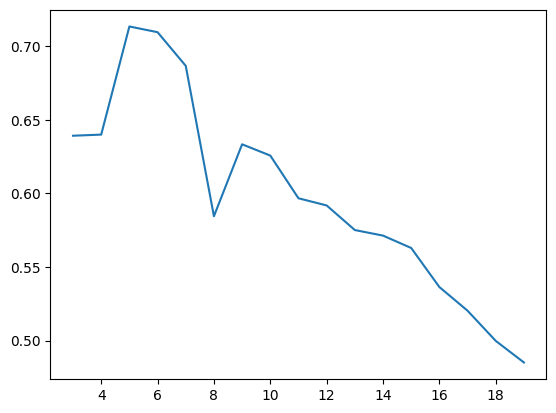

In [42]:
plt.plot(neighbours_amounts, scores)

<p>Apparently the best accuracy for our model is about 70% and it is at 5 neighbours amount. The accuracy afterward goes straight down. I don't think there's a need to testany futher because our model gets more complex at the expense of a lower accuracy. Let's see our model with 5 neighbours.</p>

In [43]:
KNN_Classifier = KNeighborsClassifier(n_neighbors=5)

In [44]:
KNN_model = KNN_Classifier.fit(X_train,Y_train)

In [45]:
y_pred = KNN_model.predict(X_test)

In [46]:
accuracy_score(y_pred, Y_test)

0.7134534469737835

<p> That accuracy on the test set seems to be good - just perfect - not too bad, not too good. But perhaps we should ask ourselves - is our model not, potentially, overfitting? Remember when we oversampled our dataset? One way to test that hypothesis is to use a model that is robust to overfitting - random forests. Let's look into it!</p>

## Random Forest 

<p> A random forest is, essentially, a lot of decision trees' output taken together for a given problem (a classification one in our case) where the output with the most frequent occurence is assumed to be the final prediction. Say we have a random forest that consist of 5 decision trees and we have 2 classes to predict - happy and sad; each decision tree would come up with an output that is one of the two classes. Let's assume that our decision trees' outputs were the following - happy, happy, happy, sad, happy. In this case the output of our random forest model would be happy because it is the majority of the predicted classes. </p>

### Decision Tree

<p> A decision tree is a machine learning algorithm which takes a certain data input and calculates the probability of a certain thing happening. Say we want to classify a text's sentiment, we'll start with some input data and calculate the probability of that input being of each class. There are a couple of ways to do that and the most often used one is the gini impurity one. Let's look into that.</p>

#### Gini impurity

<p> Gini impurity is a measure of how impure a certain data set is. Say we have a data set of 8 emails, where 5 of them are classified as spam and 3 are not spam. The gini impurity here would 1 - the sum of the probabilities of getting each email in the dataset squared. Let's write that in LaTeX and hopefully it gets a lot clearer. </p>

$ G = 1 - \sum\limits_{i=0}^n{p_i^2}$

Here G is the gini impurity - the measure of how impure a data set is, N is the amount of classes we have and p of i is the probability of picking a class "i" of all the classes in our dataset. It is squared because we want to make our model more "responsive" to the more informative/important data points in our data set - this is decided by their frequency in the dataset. It is probably important to note that the gini impurity is always between 0 and 0.5, BUT the probability of misclassifying each class is between 0 and 1!

<p> That's all cool and stuff, but why do we talk about gini impurity after all? Because decision trees need some way to know how to pick a certain node. A decision tree starts at the root and splits itself in two nodes, how does the tree know how to pick the better option? One way is to calculate the gini impurity for each node and pick the one with the lower value because lower gini value means more homogenity(more similar data, and thus more significant data) and vice-versa.</p>

<p> After all of this was said, let's write some sklearn code and test out our hypothesis - are we overfitting with our KNN model or not? The reason random forests will show that is because they are quite immune to overfitting. The reason for that is because they consist of many decision trees that use random splits of the data to train themselves on, while KNN does not do that - it just takes all of the data we give it and trains on it. </p>

## Random Forest Implementation 

We'll follow the same steps as the one we did with the K-Nearest neighbour model, so no need to comment on any of the code here.

In [56]:
RandomForest_Classifier = RandomForestClassifier(n_estimators = 3)

In [57]:
RandomForestModel = RandomForest_Classifier.fit(X_train, Y_train)

In [58]:
y_pred_random_forest_model = RandomForestModel.predict(X_test)

In [59]:
accuracy_score(y_pred_random_forest_model, Y_test)

0.7460351710001079

Well that's a bit better accuracy than the one of our KNN model with 3 neighbours amount, how about we do the elbow method here as well?

In [60]:
scores_r = []
estimators_amounts = []
for n_estimators in range(3,20):
    RandomForest_CLF = RandomForestClassifier(n_estimators = n_estimators)
    RandomForestModel = RandomForest_CLF.fit(X_train, Y_train)    
    y_pred = RandomForestModel.predict(X_test)
    y_pred_random_forest_model = RandomForestModel.predict(X_test)
    scores_r.append(score)
    estimators_amounts.append(estimators_amounts)

In [ ]:
plt.plot(estimators_amounts, scores_r)